Notebook for testing the trained models.

In [55]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import os
import pandas as pd
import torch.nn.functional as F

from lib.utils import get_free_gpu, load_lizard, debug
from lib.utils_vis import make_seed, to_rgb
from lib.EnergyCAModel import EnergyCAModel
from lib.utils import animate_steps
model_dir = 'models/'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Initialization

In [2]:

torch.backends.cudnn.benchmark = True # Speeds up stuff
torch.backends.cudnn.enabled = True

## General Parameters ##
global_params = {
    'CHANNEL_N': 16,
    'TARGET_PADDING': 16,
    'TARGET_SIZE': 40,
    'IMG_SIZE': 72,
    'MIN_STEPS': 64,
    'MAX_STEPS': 96,
}

## General Training Parameters ##
# choose cuda device with the least amount of current memory usage
training_params = {
    'lr': 2e-3,
    'betas': (0.5, 0.5),
    'n_epoch': 8000,
    'batch_size': 8,
    'device': torch.device('cuda:{}'.format(get_free_gpu()) if torch.cuda.is_available() else 'cpu'),
    'history_save_dir': 'histories/',
    'model_save_dir': 'models/',
}


Getting free GPU...
| ID | GPU  | MEM |
-------------------
|  0 |   0% |  0% |
|  1 | 100% | 90% |
|  2 |   0% |  0% |
|  3 |   0% |  0% |
|  4 |   0% |  0% |
Using GPU:  0


# Compare models through time

In [3]:
# Load all models
max_steps = global_params["MAX_STEPS"]*10

model_names = os.listdir(model_dir)
model_names = [m for m in model_names if m.endswith('.pth')]
models = []
for m in model_names:
    model = EnergyCAModel(global_params["CHANNEL_N"], training_params["device"])
    model.load_state_dict(torch.load(os.path.join(model_dir, m)))
    model.eval()
    models.append(model)

print("Loaded {} models".format(len(models)))
                   

/nfs_home/charneca/miniconda3/envs/nca/lib/python3.9/site-packages/torch/cuda/__init__.py:132: UserWarning: 
    Found GPU4 Tesla K40c which is of cuda capability 3.5.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability supported by this library is 3.7.
    
  warnings.warn(old_gpu_warn % (d, name, major, minor, min_arch // 10, min_arch % 10))


Loaded 12 models


In [4]:
# get model params
params = {
    'minFireRate': [],
    'betaEnergy': [],
}

for m in model_names:
    params['minFireRate'].append(float(m.split('minFireRate')[1].split('_')[0]))
    params['betaEnergy'].append(float(m.split('betaEnergy')[1].split('_')[0]))

debug("params")

params = {'minFireRate': [0.01, 0.05, 0.1, 0.2, 0.01, 0.05, 0.1, 0.2, 0.01, 0.05, 0.1, 0.2], 'betaEnergy': [1e-07, 1e-07, 1e-07, 1e-07, 1e-06, 1e-06, 1e-06, 1e-06, 1e-05, 1e-05, 1e-05, 1e-05]}


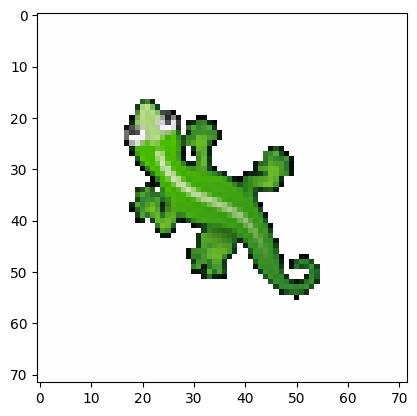

In [9]:
# Load target emoji
target_img = load_lizard('data/lizard_clean.png')
p = global_params['TARGET_PADDING']
pad_target = np.pad(target_img, [(p, p), (p, p), (0, 0)])
h, w = pad_target.shape[:2]
pad_target = np.expand_dims(pad_target, axis=0)
pad_target = torch.from_numpy(pad_target.astype(np.float32))

# Create initial state
seed = make_seed((h, w), global_params['CHANNEL_N'])
x0 = np.repeat(seed[None, ...], training_params["batch_size"], 0)
x0 = torch.from_numpy(x0.astype(np.float32)).to(training_params['device'])

plt.imshow(to_rgb(pad_target.detach().cpu()[0]))

In [35]:
# Run the models
x_steps_models = []
fireRates_steps_models = []
for model in models:
    with torch.no_grad():
        x_steps, fireRates_steps = model(x0, steps=max_steps)
    x_steps_models.append(x_steps.detach().cpu())
    fireRates_steps_models.append(fireRates_steps.detach().cpu())

        

In [36]:

# Plot losses of all models through time, averaging over the batch
losses_models = []
for x_steps in x_steps_models:
    loss = [torch.mean(F.mse_loss(x_steps[k,:,:,:,:4], pad_target)) for k in range(max_steps)]
    losses_models.append(loss)


/tmp/ipykernel_1530427/203523748.py:4: UserWarning: Using a target size (torch.Size([1, 72, 72, 4])) that is different to the input size (torch.Size([8, 72, 72, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = [torch.mean(F.mse_loss(x_steps[k,:,:,:,:4], pad_target)) for k in range(max_steps)]


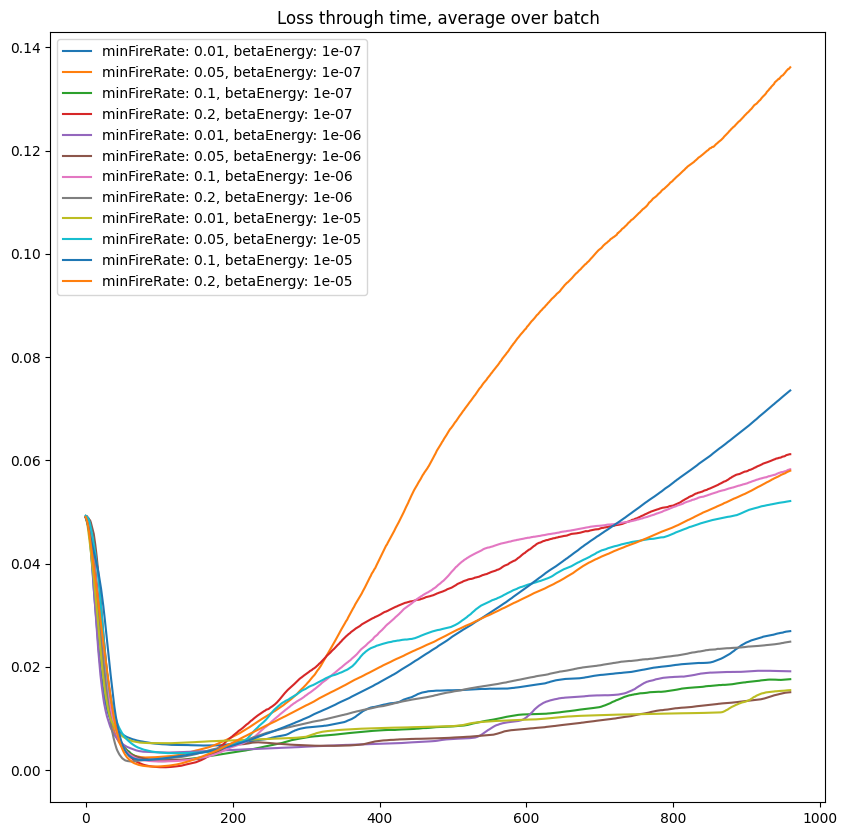

In [37]:
# plot the losses. All the plots in same axes, and each plot should have a label with the params used to train the model
plt.figure(figsize=(10, 10))
for i, l in enumerate(losses_models):
    plt.plot(l, label="minFireRate: {}, betaEnergy: {}".format(params['minFireRate'][i], params['betaEnergy'][i]))
    
plt.legend()
plt.title("Loss through time, average over batch")
plt.show()



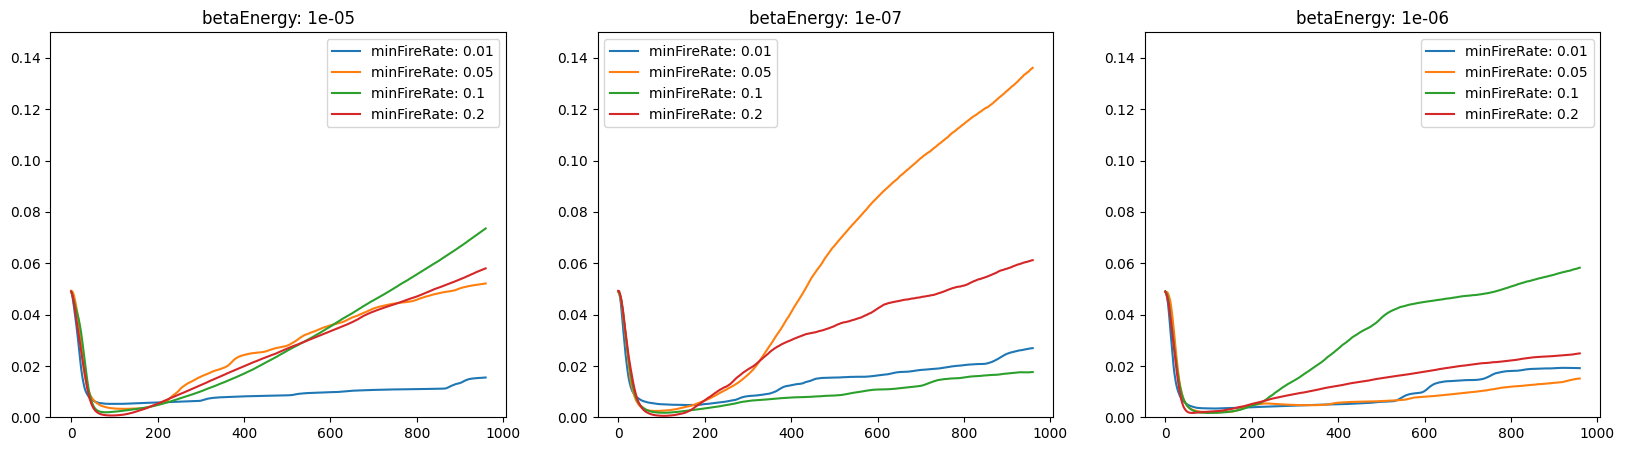

In [41]:
betaEnergy_values = list(set(params['betaEnergy']))
minFireRate_values = list(set(params['minFireRate']))

# put everything on the same y_axis, side by side
fig, axs = plt.subplots(1, len(betaEnergy_values), figsize=(20, 5))
for betaEnergy in betaEnergy_values:
    for i, l in enumerate(losses_models):
        if params['betaEnergy'][i] == betaEnergy:
            axs[betaEnergy_values.index(betaEnergy)].plot(l, label="minFireRate: {}".format(params['minFireRate'][i]))
            axs[betaEnergy_values.index(betaEnergy)].set_ylim([0, 0.15])
    axs[betaEnergy_values.index(betaEnergy)].set_title("betaEnergy: {}".format(betaEnergy))
    axs[betaEnergy_values.index(betaEnergy)].legend()

    

plt.show()


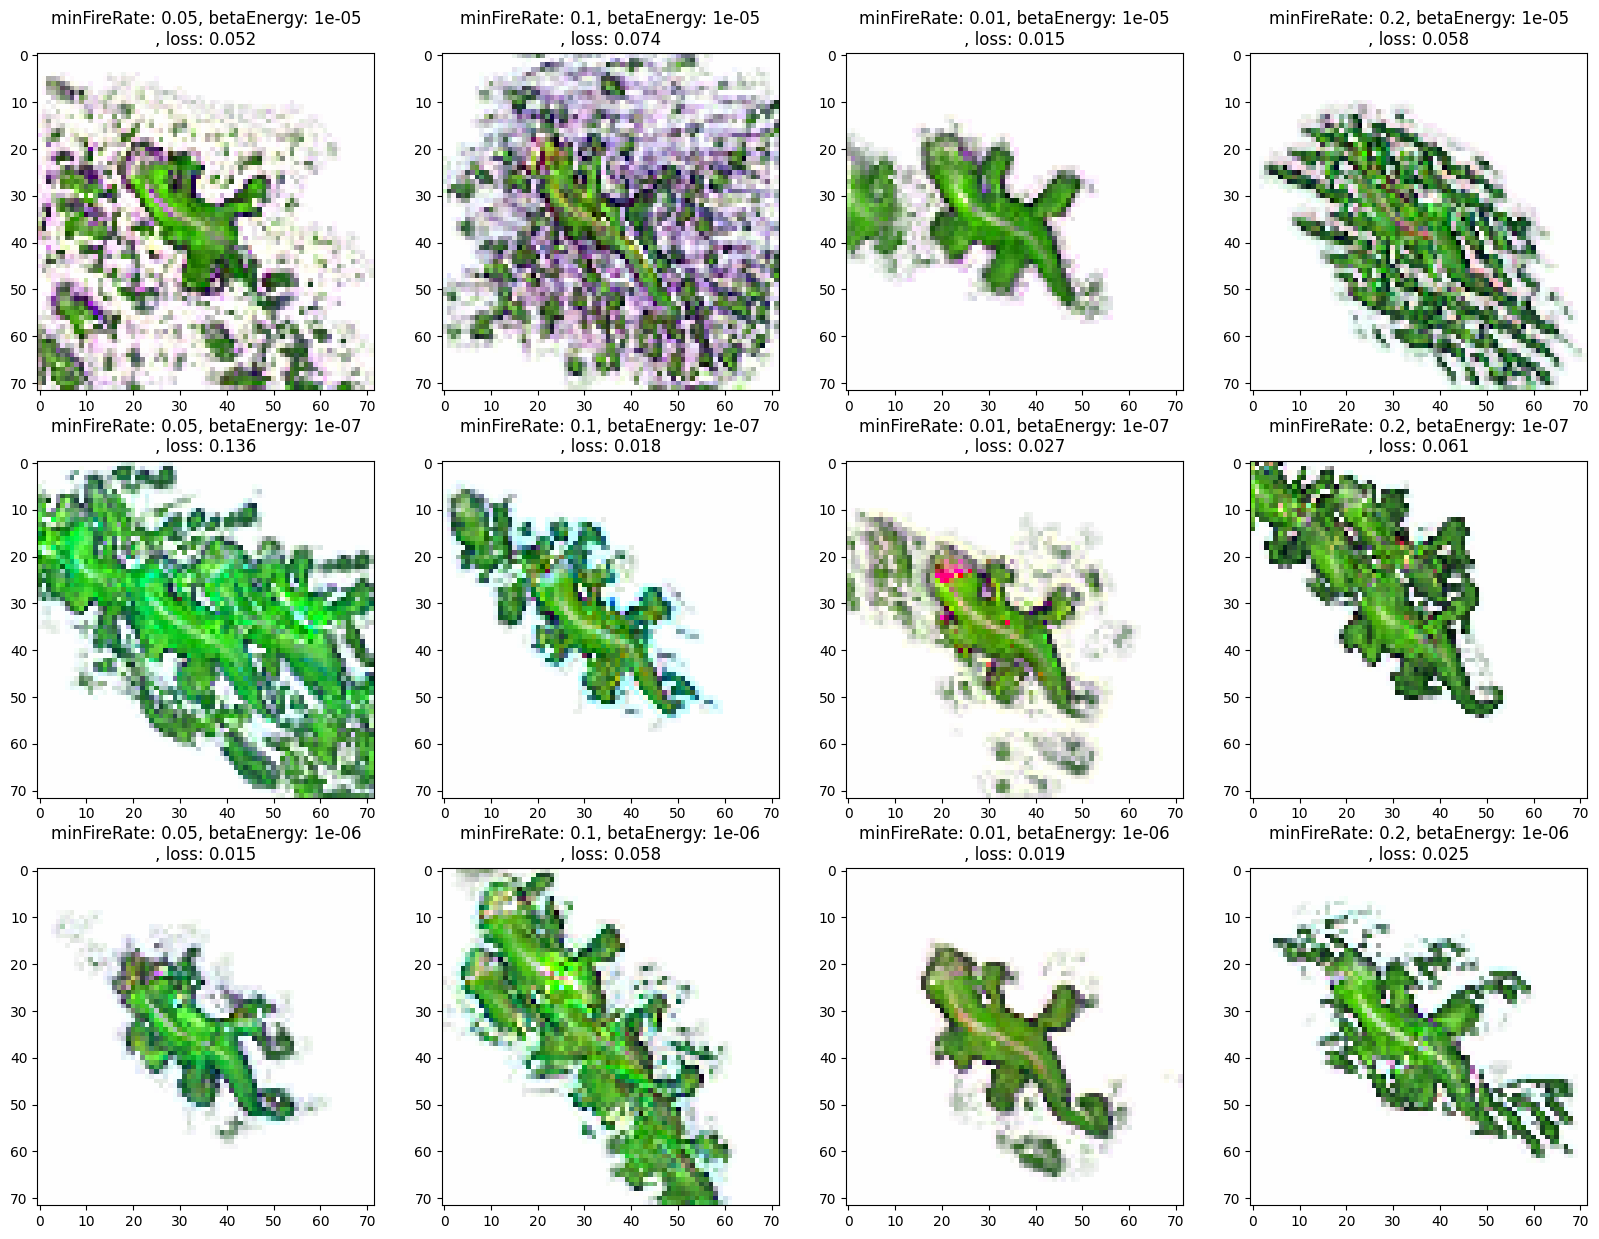

In [54]:
# Show final images in a grid, in which each row is a different betaEnergy, and each column is a different minFireRate.
# The title of each image should be the model params and the  loss at the end of the simulation
fig, axs = plt.subplots(len(betaEnergy_values), len(minFireRate_values), figsize=(20, 15))
for betaEnergy in betaEnergy_values:
    for minFireRate in minFireRate_values:
        for i, x_steps in enumerate(x_steps_models):
            if params['betaEnergy'][i] == betaEnergy and params['minFireRate'][i] == minFireRate:
                axs[betaEnergy_values.index(betaEnergy), minFireRate_values.index(minFireRate)].imshow(to_rgb(x_steps[-1,0,:,:,:4]))
                axs[betaEnergy_values.index(betaEnergy), minFireRate_values.index(minFireRate)].set_title("minFireRate: {}, betaEnergy: {}\n, loss: {:.3f}".format(params['minFireRate'][i], params['betaEnergy'][i], losses_models[i][-1]))
plt.show()


    

In [57]:
# Create dictionary with keys {minFireRate, betaEnergy, x_steps, fireRates_steps, final_loss, final_image}
results = []
for i, x_steps in enumerate(x_steps_models):
    results.append({
        'minFireRate': params['minFireRate'][i],
        'betaEnergy': params['betaEnergy'][i],
        'x_steps': x_steps,
        'fireRates_steps': fireRates_steps_models[i],
        'final_loss': losses_models[i][-1],
        'final_image': to_rgb(x_steps[-1,0,:,:,:4])
    })

# Sort by final_loss
results = sorted(results, key=lambda k: k['final_loss'])

# print the final loss and params of the 5 best models
print("Top 5 models, measured with the final loss")
for i in range(5):
    print("minFireRate: {}, betaEnergy: {}, loss: {:.3f}".format(results[i]['minFireRate'], results[i]['betaEnergy'], results[i]['final_loss']))



Top 5 models, measured with the final loss
minFireRate: 0.05, betaEnergy: 1e-06, loss: 0.015
minFireRate: 0.01, betaEnergy: 1e-05, loss: 0.015
minFireRate: 0.1, betaEnergy: 1e-07, loss: 0.018
minFireRate: 0.01, betaEnergy: 1e-06, loss: 0.019
minFireRate: 0.2, betaEnergy: 1e-06, loss: 0.025


In [59]:
debug("results[0]['x_steps'].shape")

results[0]['x_steps'].shape = torch.Size([960, 8, 72, 72, 16])


In [62]:
# show animation
animate_steps(
    to_rgb(results[0]['x_steps']),
)

# Create table with params vs loss

In [13]:
# Sort models in /models by the average loss of the last 100 epochs. This loss history is saved in the /histories folder, as a .csv val, in the loss_rec_val column.

model_names = os.listdir(model_dir)
model_names = [m for m in model_names if m.endswith('.pth')]

# substitute the _epoch8000.pth with _history.csv
hist_names = [m.replace('_epoch8000.pth', '_history.csv') for m in model_names]

# load the histories into dataframes. Each model name has the numerical hyperpameters in it, so we'll create a dataframe with the columns:
# minFireRate
# betaEnergy
# avgLoss_last100

# first, get parameters from model names
params = {
    'minFireRate': [],
    'betaEnergy': [],
}

for m in model_names:
    params['minFireRate'].append(float(m.split('minFireRate')[1].split('_')[0]))
    params['betaEnergy'].append(float(m.split('betaEnergy')[1].split('_')[0]))

print(params)
# now, load the histories
histories = []
for h in hist_names:
    histories.append(pd.read_csv(os.path.join(training_params['history_save_dir'], h)))

# now, create the dataframe
df = pd.DataFrame(params)

# now, add the average loss of the last 100 epochs
avgLoss_last100 = []
for h in histories:
    avgLoss_last100.append(h['loss_rec_val'].iloc[-100:].mean())

df['avgLoss_last100'] = avgLoss_last100

# now, sort by avgLoss_last100
df = df.sort_values(by='avgLoss_last100')
df




{'minFireRate': [0.01, 0.05, 0.1, 0.2, 0.01, 0.05, 0.1, 0.2, 0.01, 0.05, 0.1, 0.2], 'betaEnergy': [1e-07, 1e-07, 1e-07, 1e-07, 1e-06, 1e-06, 1e-06, 1e-06, 1e-05, 1e-05, 1e-05, 1e-05]}


,minFireRate,betaEnergy,avgLoss_last100
3,0.20,1.000000e-07,0.000850
7,0.20,1.000000e-06,0.000953
11,0.20,1.000000e-05,0.001138
6,0.10,1.000000e-06,0.001538
2,0.10,1.000000e-07,0.001751
10,0.10,1.000000e-05,0.002246
5,0.05,1.000000e-06,0.002468
1,0.05,1.000000e-07,0.002569
9,0.05,1.000000e-05,0.002973
4,0.01,1.000000e-06,0.004059


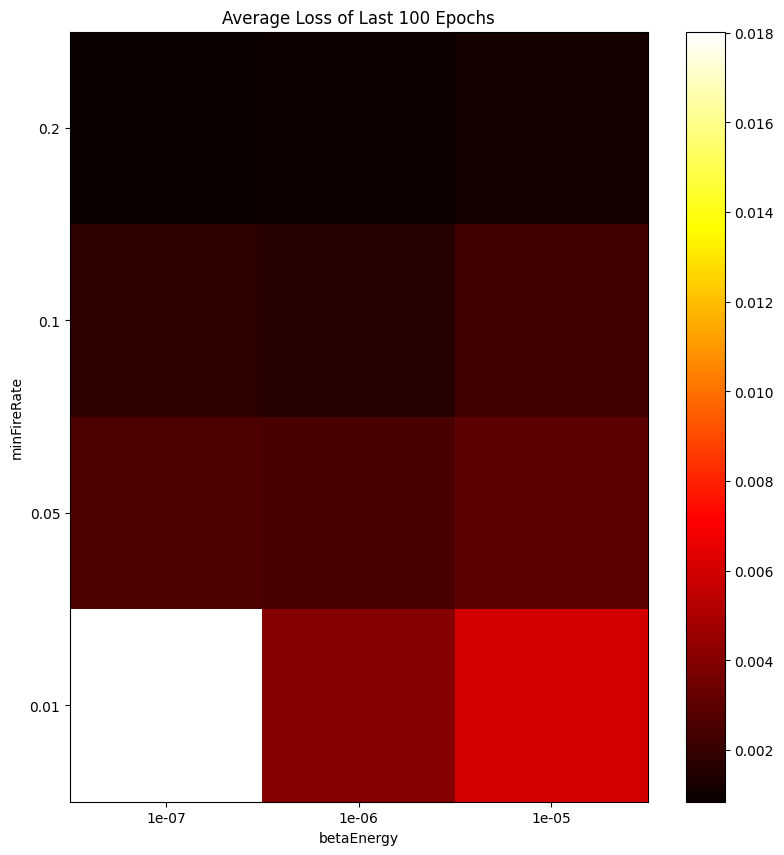

In [14]:
# Now create a table, where the rows are the minFireRate, and the columns are the betaEnergy. The values are the avgLoss_last100

# first, create the table
table = np.zeros((len(df['minFireRate'].unique()), len(df['betaEnergy'].unique())))
# now, fill it
for i, m in enumerate(df['minFireRate'].unique()):
    for j, b in enumerate(df['betaEnergy'].unique()):
        table[i, j] = df.loc[(df['minFireRate'] == m) & (df['betaEnergy'] == b), 'avgLoss_last100'].values[0]

# now, plot it
plt.figure(figsize=(10, 10))
plt.imshow(table, cmap='hot', interpolation='nearest')
plt.xticks(np.arange(len(df['betaEnergy'].unique())), df['betaEnergy'].unique())
plt.yticks(np.arange(len(df['minFireRate'].unique())), df['minFireRate'].unique())
plt.xlabel('betaEnergy')
plt.ylabel('minFireRate')
plt.title('Average Loss of Last 100 Epochs')
plt.colorbar()
plt.show()
